In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import random
import numpy as np

In [3]:
#Carregar arquivo de tempo x distância
data = pd.read_excel(r'.\xls\tempodist.xls', sheet_name='Plan2')
data

,Tempo (Y),Distância (X)
0,15,8
1,20,6
2,20,15
3,40,20
4,50,25
5,25,11
6,10,5
7,55,32
8,35,28
9,30,20


In [4]:
#Estatística univariadas
data[['Tempo (Y)', 'Distância (X)']].describe()


,Tempo (Y),Distância (X)
count,10.00000,10.000000
mean,30.00000,17.000000
std,14.90712,9.510228
min,10.00000,5.000000
25%,20.00000,8.750000
50%,27.50000,17.500000
75%,38.75000,23.750000
max,55.00000,32.000000


Criando um objecto para calcular a regressão linear

Equação da Reta: $y = A + Bx$

coeficiênte angular (B): $$B = \frac{n\sum x_{i}y_{i} - \sum x_{i} \sum y_{i}}{n \sum x_{i}^{2} - (\sum x_{i}^{2})}$$

coeficiênte linear (A): $$A = \frac{\sum y - B . \sum x}{n}$$

coeficiênte de correlação:

$$ r_{x,y} = \frac{n \sum x_{i} y_{i} - \sum x_{i} \sum y_{i}}{\sqrt{n \sum x_{i}^{2} - (\sum x_{i})^{2}} \sqrt{n \sum y_{i}^{2} - (\sum y_{i})^{2}}}$$


0    635.857560
1    311.951972
2    850.037664
3    241.508400
4    142.221740
5    362.799534
6    696.175356
7    251.693937
8    945.978086
9    652.319211
Name: erro², dtype: float64
    x   y    x²    y²    xy       yhat       erro       erro²  yhat_ajustado
0   8  15    64   225   120  40.216216 -25.216216  635.857560  -4.615267e+12
1   6  20    36   400   120  37.662162 -17.662162  311.951972  -6.054618e+12
2  15  20   225   400   300  49.155405 -29.155405  850.037664   6.562926e+11
3  20  40   400  1600   800  55.540541 -15.540541  241.508400   1.234777e+13
4  25  50   625  2500  1250  61.925676 -11.925676  142.221740   3.403166e+12
5  11  25   121   625   275  44.047297 -19.047297  362.799534  -1.292937e+13
6   5  10    25   100    50  36.385135 -26.385135  696.175356  -5.797304e+12
7  32  55  1024  3025  1760  70.864865 -15.864865  251.693937   7.588750e+12
8  28  35   784  1225   980  65.756757 -30.756757  945.978086   5.660406e+12
9  20  30   400   900   600  55.540541 -25

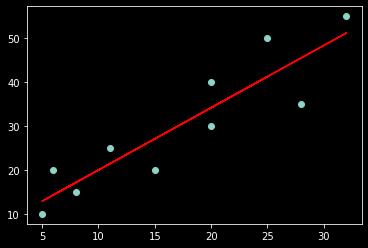

In [82]:
plt.scatter(x = rlm.matriz['x'], y = rlm.matriz['y'])
plt.plot(rlm.matriz['x'], rlm.matriz['yhat'], color = 'red')

# MÉTODO DOS MÍNIMOS QUADRADOS

**Erro:**
    $$erro_{i} = \sum_{i = 1}^{n}y_{i} - \hat{y} $$

Está somatória deve ser igual a Zero
    
**Erro Qudrado:**

$$erro = y_{i} - \hat{y}$$

$$\sum\limits _{i = 1}^{n} erro^{2}$$



Coeficiente Linear quadratico:
$$a = \overline{y} - b\overline{x}$$


Coeficiente Angular quadratico:

$$b = \frac{\sum\limits _{i = 1} ^{n}(x_{i} - \overline{x})(y_{i} - \overline{y})}{\sum\limits_{i = 1}^{n} (x_{i} - \overline{x})^{2}}$$



In [19]:
rlm.coefA

30.0